In [1]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# FUNCTIONS
def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return [roll, pitch, yaw]

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def unwrap_angle(angle_array):
    unwrapped = np.copy(angle_array)
    k_now = 0
    angle_before = 0
    for i in range(len(unwrapped)):
        if ((angle_before < -2) and (unwrapped[i] > 2)):
            k_now = k_now - 1
        elif ((angle_before > 2) and (unwrapped[i] < -2)):
            k_now = k_now + 1
        angle_before = unwrapped[i]
        unwrapped[i] += (k_now * 2 *np.pi)
    return unwrapped

def reindex_value(source_val, source_idx, target_idx, target_val=None):
#     if (target_val!=None):
#         no_tval = True
#         target_val = np.copy(target_idx)
    no_tval = False
    try:
        _ = target_val.shape
    except:
        no_tval = True
        target_val = np.copy(target_idx)
    # FIND INDEX INTERSECTION
    latest_start_idx = max(source_idx[0],
                           target_idx[0])
    earliest_start_idx =min(source_idx[0],
                           target_idx[0])
    earliest_end_idx = min(source_idx[-1],
                           target_idx[-1])
    # CONVERT TO PD.DF
    source_pd = pd.DataFrame(index = source_idx,
                             data = source_val)
    target_pd = pd.DataFrame(index = target_idx,
                             data = target_val)
    # DROP DUPLICATED INDEX
    source_pd = source_pd[~source_pd.index.duplicated()]
    target_pd = target_pd[~target_pd.index.duplicated()]
    # SLICE DATA IN INTERSECTION
    source_pd = source_pd.reindex(source_pd.index.union([latest_start_idx,
                                                         earliest_end_idx])).interpolate(method='index')
    time_mask = (source_pd.index >= latest_start_idx) &\
                (source_pd.index <= earliest_end_idx)
    source_pd = source_pd.loc[time_mask]
    
    target_pd = target_pd.reindex(target_pd.index.union([latest_start_idx,
                                                         earliest_end_idx])).interpolate(method='index')
    time_mask = (target_pd.index >= latest_start_idx) &\
                (target_pd.index <= earliest_end_idx)
    target_pd = target_pd.loc[time_mask]
    # REINDEX SOURCE_VAL
    source_pd = source_pd.reindex(source_pd.index.union(target_pd.index))\
                                        .interpolate(method='index')\
                                        .reindex(target_pd.index)
    # CONVERT BACK TO NP ARRAY
    _sval = source_pd.to_numpy()
    _sidx = source_pd.index.to_numpy()
    
    if (no_tval==False):
        _tval = target_pd.to_numpy()
        _tidx = target_pd.index.to_numpy()
        return _sval, _sidx, _tidx, _tval
    else:
        return _sval, _sidx

In [3]:
def get_abs_dist(point, waypoints):
    temp = 1e12
    for wp_ in waypoints:
        dist = np.abs(np.linalg.norm(point - wp_[:-3]))
        if dist<temp:
            temp=dist
    
    return temp

def get_sq_dist(point, waypoints):
    temp = 1e12
    for wp_ in waypoints:
        dist = np.square(np.linalg.norm(point - wp_[:-3]))
        if dist<temp:
            temp=dist
    
    return temp

In [4]:
def mae(points, waypoints):
    err = 0
    n = points.shape[0]
    for point in points:
        err += get_abs_dist(point, waypoints)
        
    return err/n

def mse(points, waypoints):
    err = 0
    n = points.shape[0]
    for point in points:
        err += get_sq_dist(point, waypoints)
        
    return err/n

def rmse(points, waypoints):
    err = 0
    n = points.shape[0]
    for point in points:
        err += get_sq_dist(point, waypoints)
        
    return np.sqrt(err/n)

In [435]:
def get_longest_dist(points, waypoints):
    temp = 0
    for point in points:
        dist = get_abs_dist(point, waypoints)
        if dist>temp:
            temp = dist
    return temp

In [498]:
# IMPORT DATA
_bagfolder = "result/"
_bagfilename = "p5_ld_3"
bag = rosbag.Bag(_bagfolder+_bagfilename+".bag")
print(bag)

path:        result/p5_ld_3.bag
version:     2.0
duration:    17.4s
start:       May 19 2021 20:23:19.05 (1621430599.05)
end:         May 19 2021 20:23:36.45 (1621430616.45)
size:        2.6 MB
messages:    8214
compression: none [4/4 chunks]
types:       diagnostic_msgs/DiagnosticArray       [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config            [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/TwistStamped            [98d34b0043a2093cf9d9345ab6eef12e]
             golfi/ukf_states                      [38d0f35cc2cbdd4f2de2e8d12d845144]
             local_planner/Camera                  [82a48f852eaf431c359f63ae6647045a]
             local_planner/Planner                 [c22f4c778f0c956764c8ed2b49af91e2]
             nav_msgs/Odometry                     [cd5e73d190d741a2f92e81eda573aca7]
             pkg_ta/Control                        [95b6622e1ca744690

In [499]:
# CHECK MSG FORMAT
_bagdata = []
for topic, msg, t in bag.read_messages(topics=['/ukf_states']):
    _bagdata.append([msg, t.to_sec()])
print(_bagdata[200])

[stamp: 
  secs: 1621430603
  nsecs: 252610923
x: 784347.9140416515
y: 9239768.118346103
vx: -1.025123953819275
vy: 0.0939231663942337
vx_gnss: -0.7635127380490303
vy_gnss: 0.09355317801237106
v_gnss: 0.7692229184568941
v_tach: 0.0
yaw_est: -2.563739538192749
yaw_imu: 2.1488494873046875
yaw_dydx: 3.0196704864501953, 1621430603.2528126]


In [500]:
_wpdata = []
pln_xy = []
for topic, msg, t in bag.read_messages(topics=['/wp_planner']):
    _wpdata.append([msg, t.to_sec()])
    pln_xy.append([msg.x, msg.y])
pln_xy = np.array(pln_xy)
print(pln_xy.shape)
print(pln_xy[0])

(5, 2, 49)
[[ 784348.57050129  784348.4220874   784348.27368188  784348.12529211
   784347.97692443  784347.82858415  784347.68027564  784347.53200232
   784347.38376671  784347.23557043  784347.08741422  784346.93929796
   784346.79122066  784346.64318055  784346.49517502  784346.34720077
   784346.19925376  784346.05132936  784345.90342236  784345.75552709
   784345.60763748  784345.45974716  784345.31184959  784345.16393811
   784345.0160061   784344.86804703  784344.72005462  784344.57202289
   784344.42394627  784344.2758197   784344.1276387   784343.97939941
   784343.83109869  784343.68273413  784343.53430409  784343.38580773
   784343.23724498  784343.08861656  784342.93992394  784342.79116932
   784342.64235559  784342.49348626  784342.34456545  784342.19559782
   784342.04658853  784341.89754322  784341.74846799  784341.59936945
   784341.45025473]
 [9239768.04484803 9239768.06441168 9239768.08403859 9239768.10378423
  9239768.12369505 9239768.14380894 9239768.16415564 923976

In [501]:
# TAKE UKF DATA
ukf_t = []
ukf_xy = []
ukf_v = []
ukf_yaw_est = []
ukf_yaw_imu = []
ukf_yaw_dydx = []
for topic, msg, t in bag.read_messages(topics=['/ukf_states']):
    ukf_t.append(t.to_sec())
    ukf_xy.append([msg.x, msg.y])
    ukf_v.append([msg.vx, msg.vy])
    ukf_yaw_est.append(msg.yaw_est)
    ukf_yaw_imu.append(msg.yaw_imu)
    ukf_yaw_dydx.append(msg.yaw_dydx)
ukf_t = np.array(ukf_t)
ukf_xy = np.array(ukf_xy)
ukf_yaw_est = np.array(ukf_yaw_est)
ukf_yaw_imu = np.array(ukf_yaw_imu)
ukf_yaw_dydx = np.array(ukf_yaw_dydx)
print(ukf_xy[:3])

[[ 784348.67682691 9239768.03214247]
 [ 784348.6760813  9239768.03439071]
 [ 784348.6753557  9239768.03668243]]


In [472]:
vel = []
for v in ukf_v:
    vel.append(v[0]**2 + v[1]**2)

print(vel[:3])

[0.009615556712650644, 0.011395201565622959, 0.013259869327227336]


In [439]:
# GET WAYPOINTS
_wpfolder = "result/"
_wpfilename = "wp_ta_rev"
wp = np.load(_wpfolder + _wpfilename + ".npy")

print(wp[:3])

[[ 7.84346850e+05  9.23976861e+06 -2.52920675e+00  1.00000000e+00
  -2.42446667e-02]
 [ 7.84346834e+05  9.23976861e+06 -2.52960658e+00  9.78974667e-01
   5.53906793e-02]
 [ 7.84346817e+05  9.23976861e+06 -2.52868390e+00  9.72411275e-01
   6.36636891e-02]]


In [52]:
avg_x = wp[-1][0]
avg_y = wp[0][1]
print(avg_x, avg_y)

784306.736386915 9239770.454634322


In [181]:
print('MAE: %.4f' %mae(ukf_xy, wp))
print('MSE: %.4f' %mse(ukf_xy, wp))
print('RMSE: %.4f' %rmse(ukf_xy, wp))

MAE: 1.6551
MSE: 4.3317
RMSE: 2.0813


In [502]:
print('Maximum Dev: %.4f' %get_longest_dist(ukf_xy, wp))

Maximum Dev: 1.9199


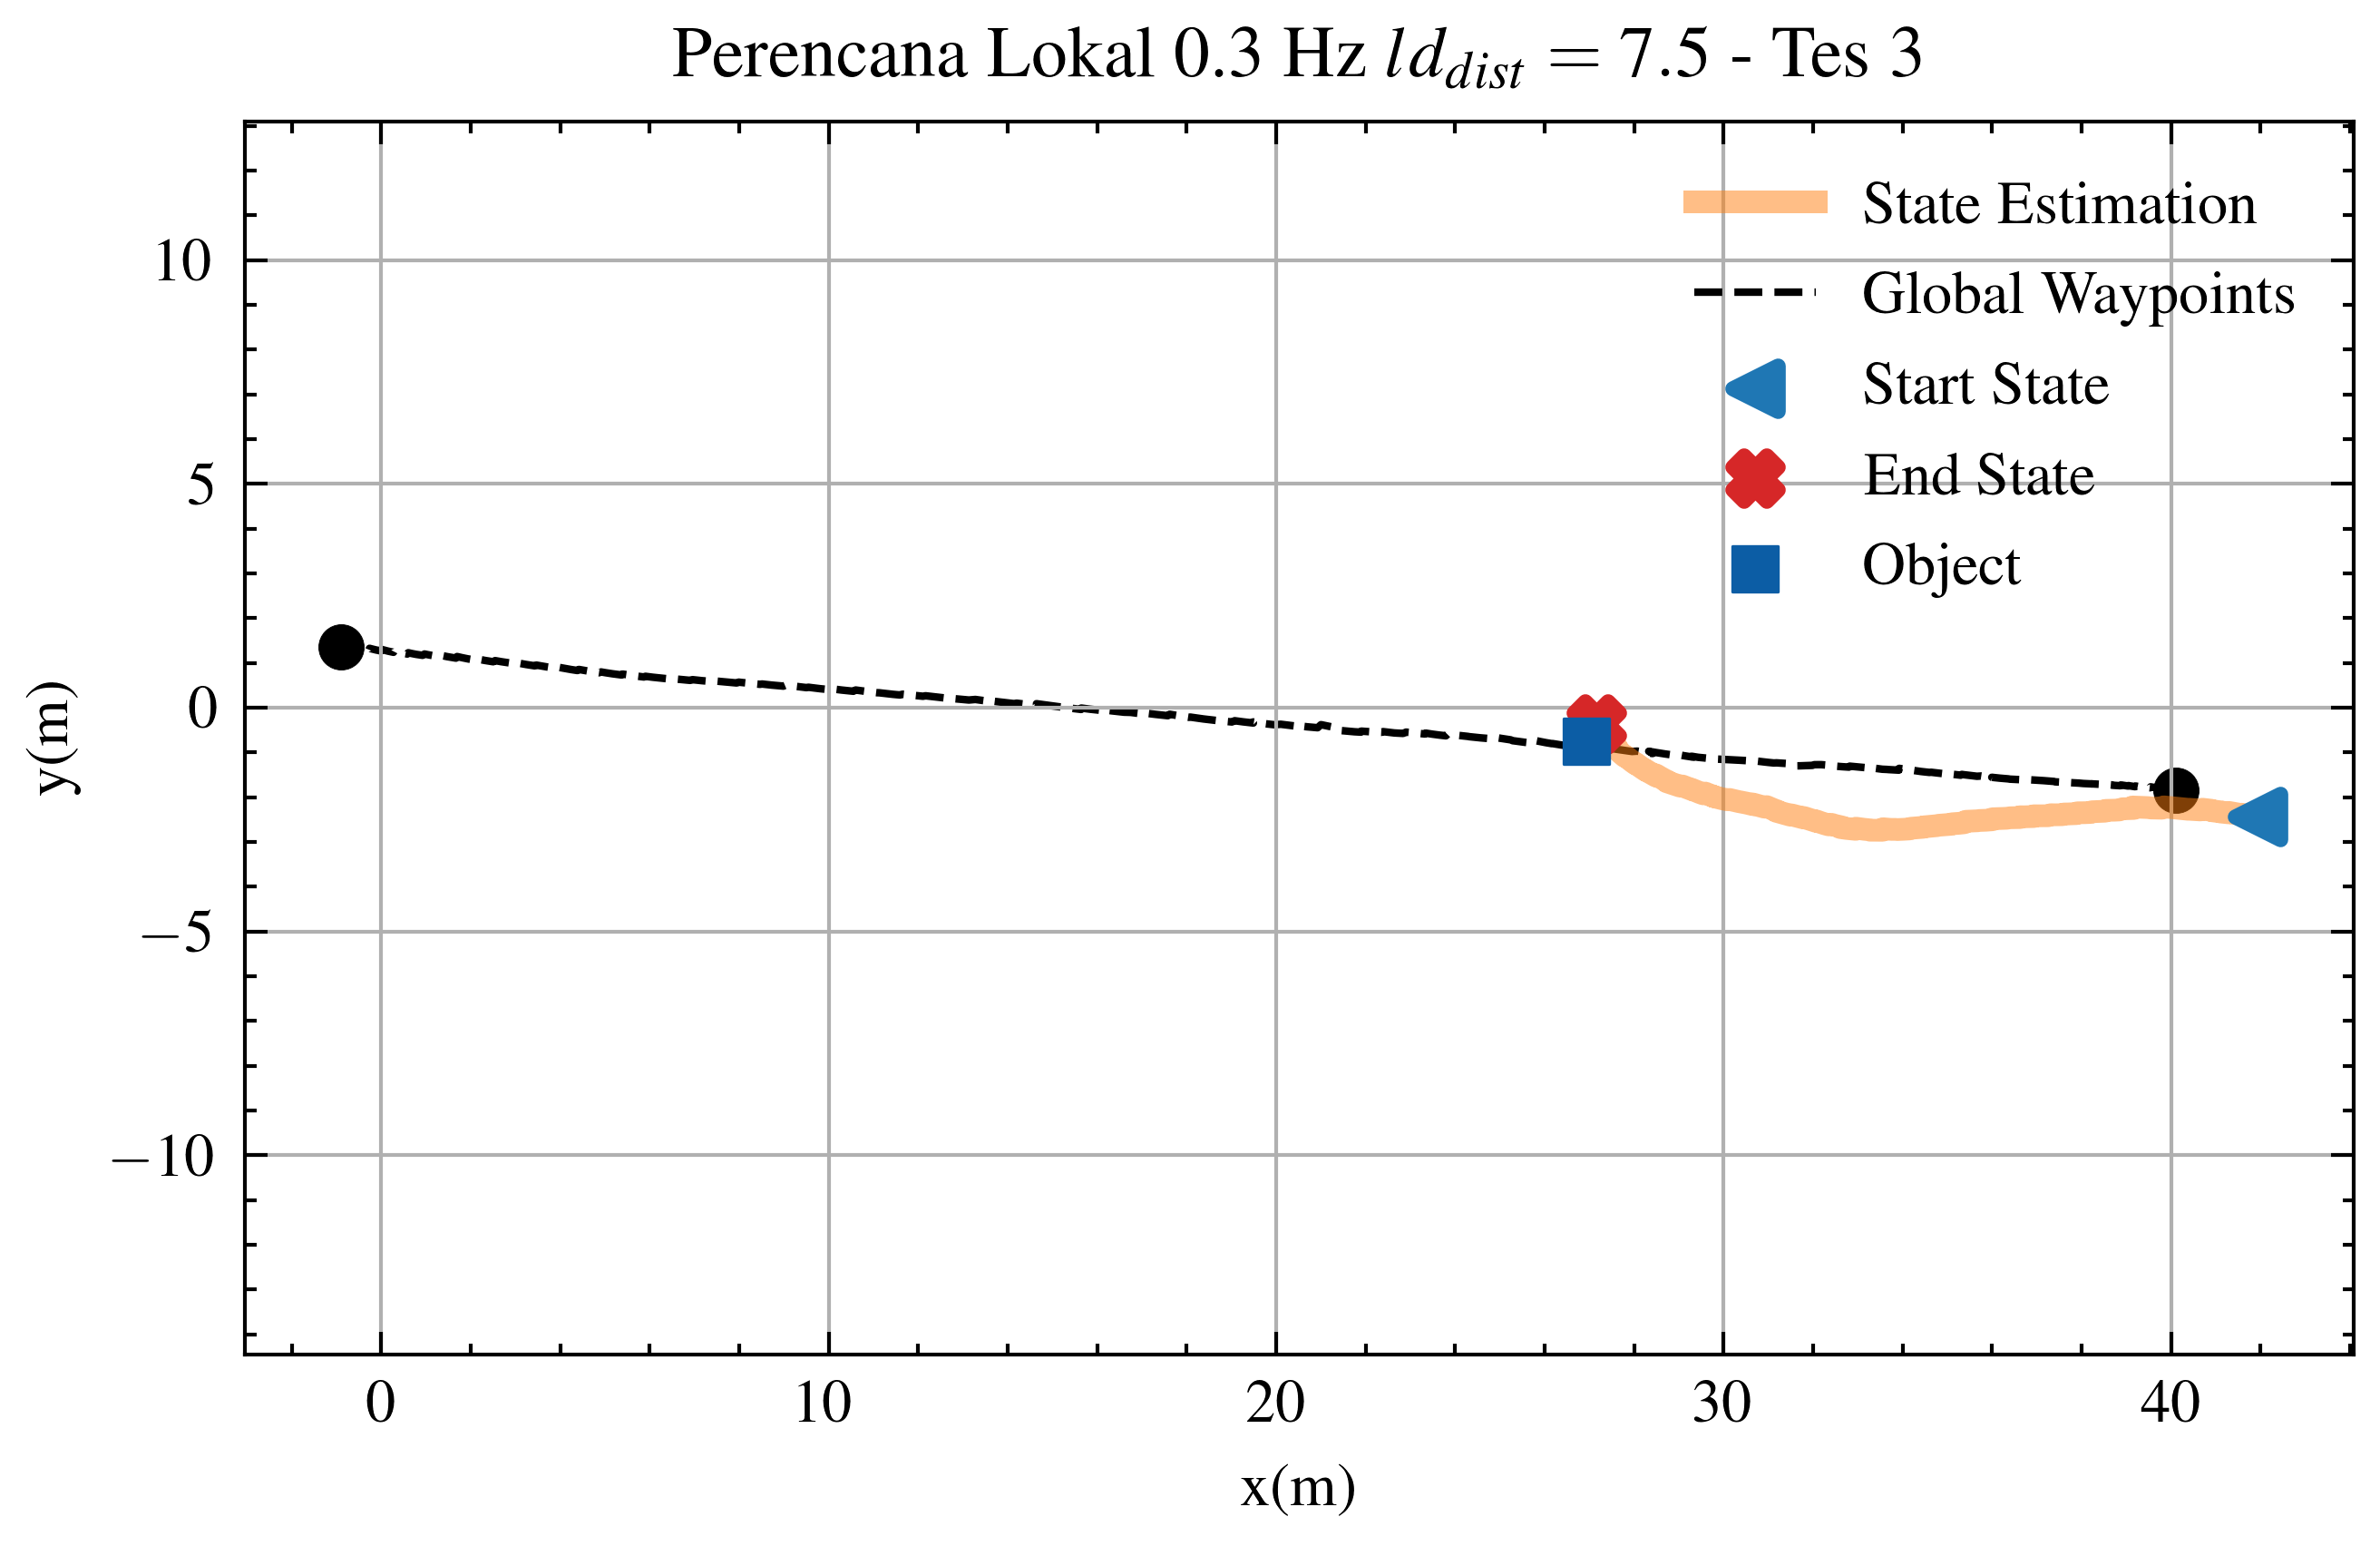

In [503]:
# PLOT

plt.style.use(['ieee', 'science'])
plt.figure(figsize=(5,3))
# UKF
plt.scatter(ukf_xy[0,0]-avg_x, ukf_xy[0,1]-avg_y, label="Start State", marker='<', c='tab:blue', lw=2, zorder=3)
plt.scatter(ukf_xy[-1,0]-avg_x, ukf_xy[-1,1]-avg_y, label="End State", marker='X', c='tab:red', lw=2, zorder=3)
plt.plot(ukf_xy[:,0]-avg_x, ukf_xy[:,1]-avg_y, label="State Estimation", lw=3, c="tab:orange", zorder=2, alpha=0.5)
# Waypoints
plt.scatter(wp[0,0]-avg_x, wp[0,1]-avg_y, c='black', lw=0.1, zorder=1)
plt.scatter(wp[-1,0]-avg_x, wp[-1,1]-avg_y, c='black', lw=0.1, zorder=1)
plt.plot(wp[:,0]-avg_x, wp[:,1]-avg_y, '--', label="Global Waypoints", c="black", zorder=1)
# Object
plt.scatter(ukf_xy[0,0]-avg_x-15, -0.75, lw=0.4, marker='s', label='Object', zorder=3)
plt.axis("equal")
plt.title('Perencana Lokal 0.3 Hz $ld_{dist}=7.5$ - Tes 3')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.grid()
plt.savefig('img/'+_bagfilename+'.png', dpi=300, facecolor='white')

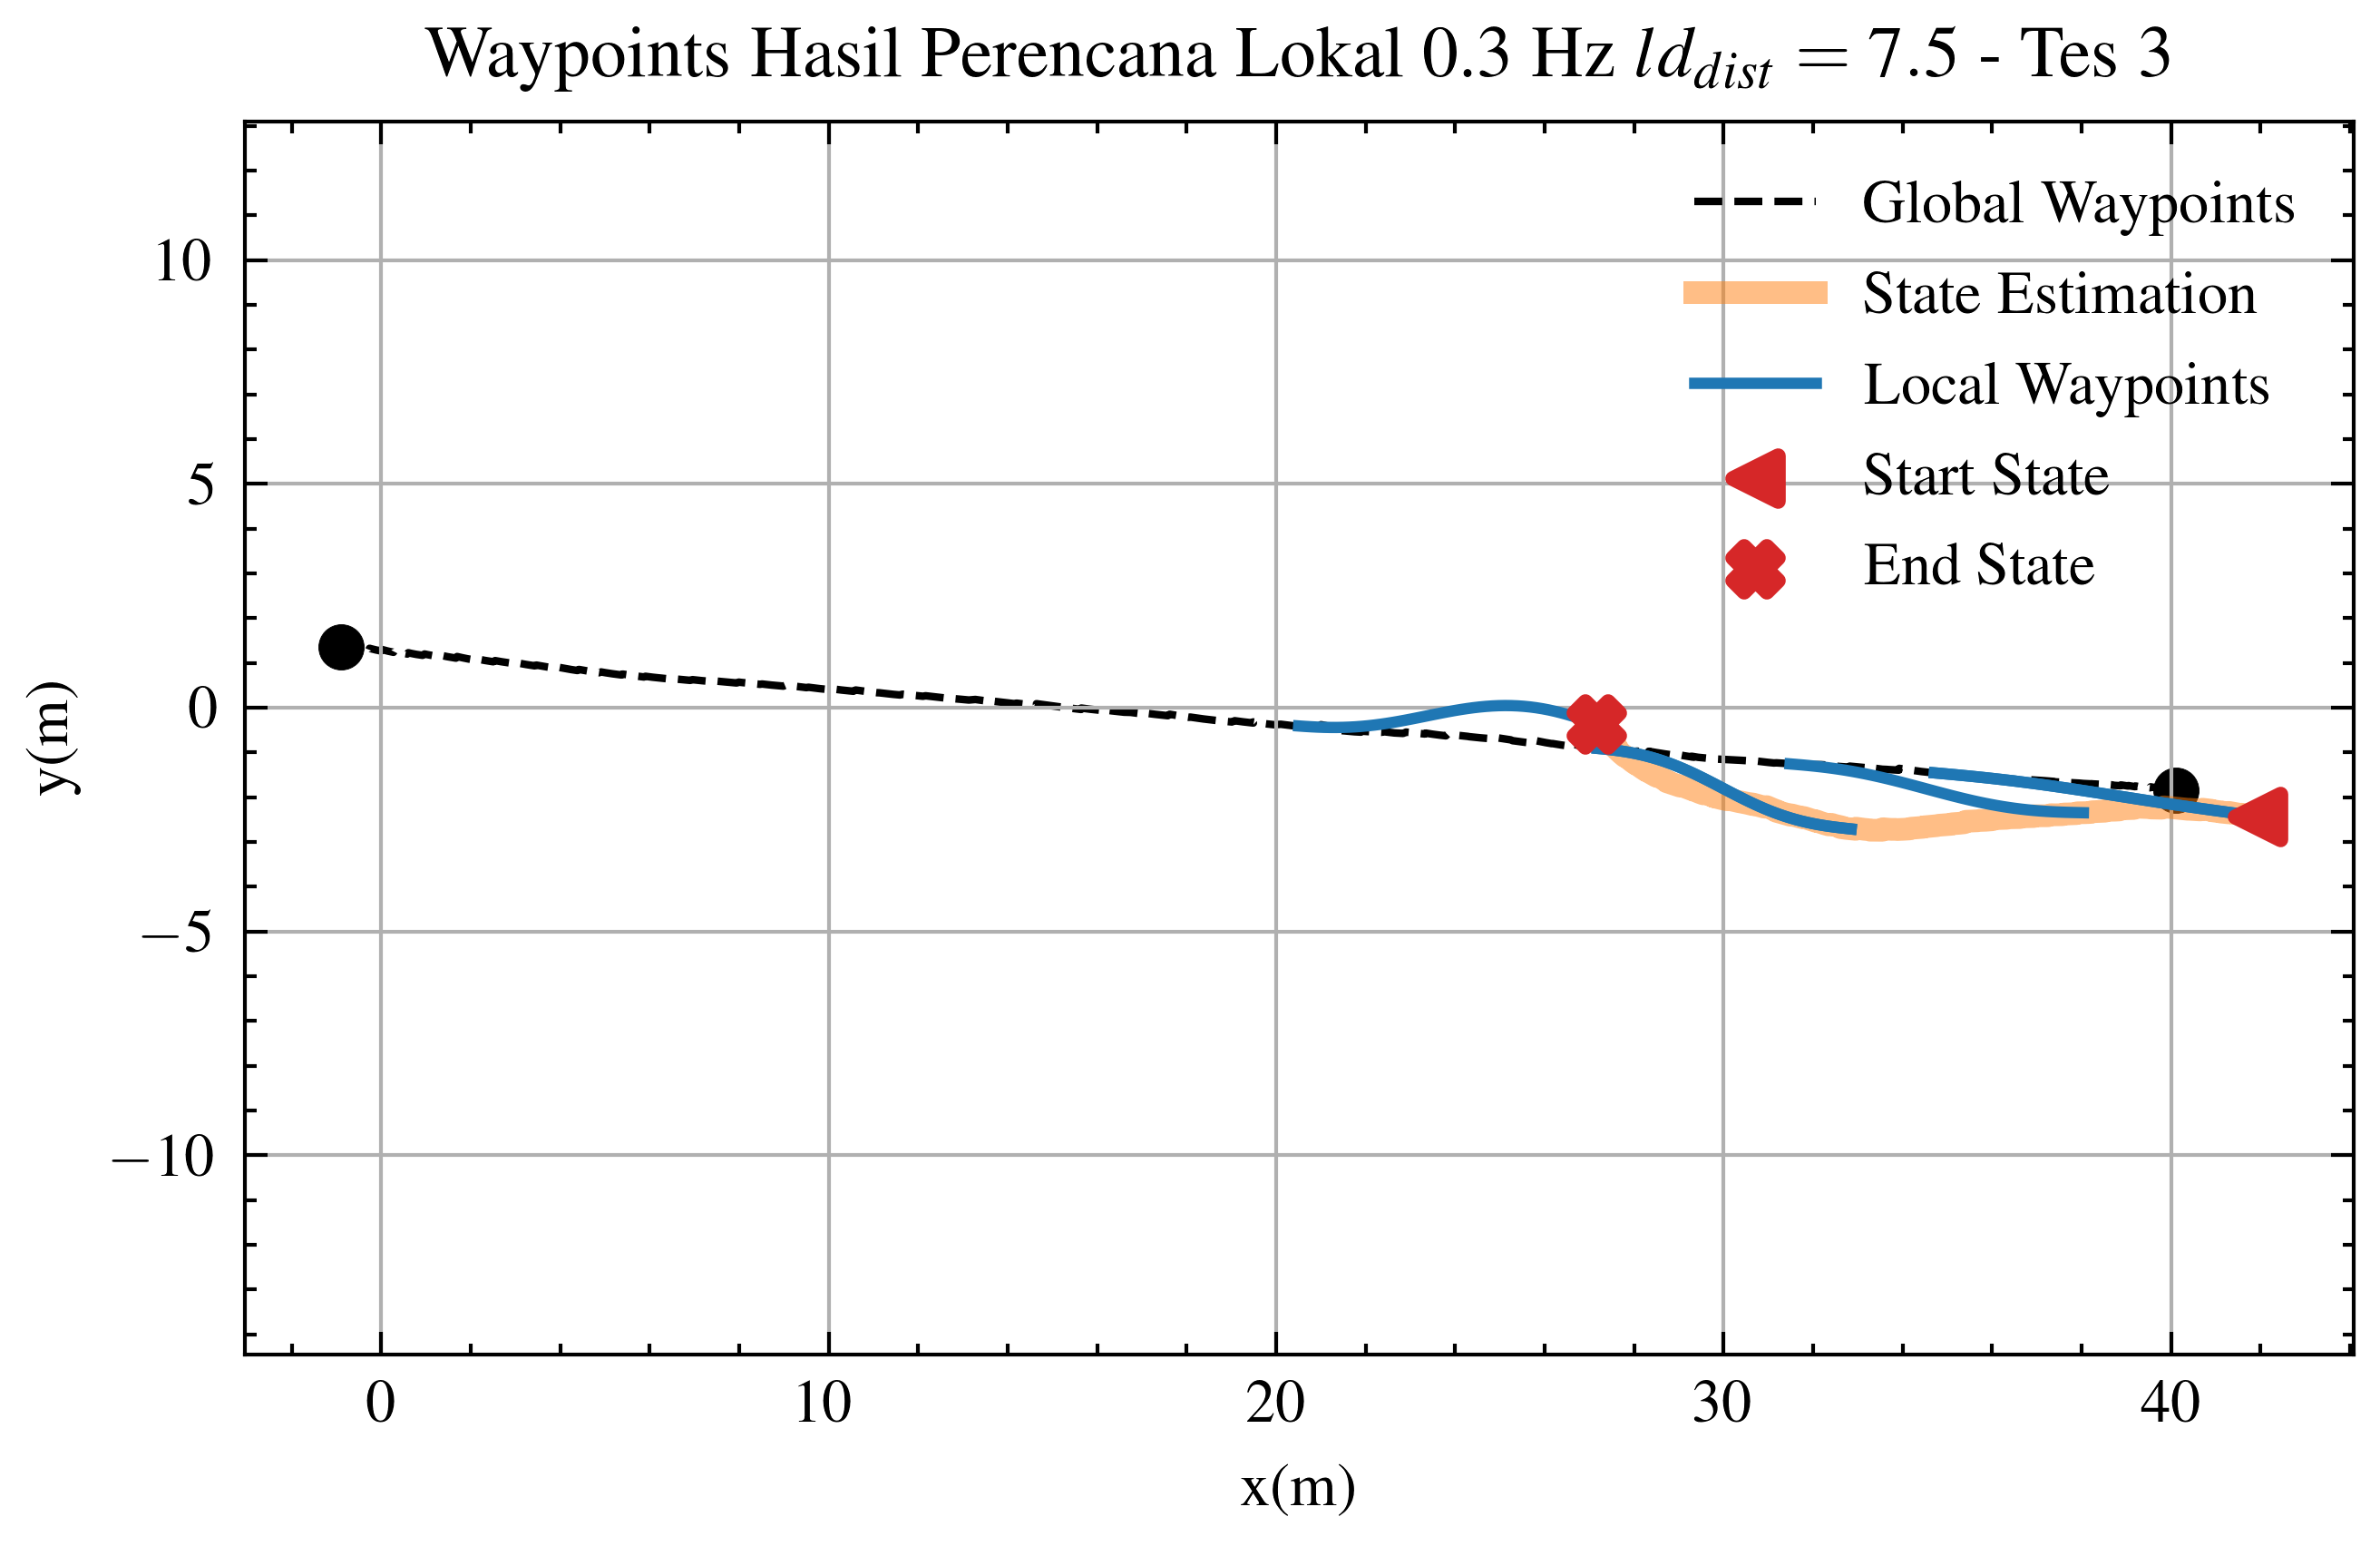

In [505]:
plt.style.use(['ieee', 'science'])
plt.figure(figsize=(5, 3))

# UKF
plt.scatter(ukf_xy[0,0]-avg_x, ukf_xy[0,1]-avg_y, label="Start State", marker='<', c='tab:red', lw=2, zorder=3)
plt.scatter(ukf_xy[-1,0]-avg_x, ukf_xy[-1,1]-avg_y, label="End State", marker='X', c='tab:red', lw=2, zorder=3)

# Waypoints
plt.scatter(wp[0,0]-avg_x, wp[0,1]-avg_y, c='black', lw=0.1, zorder=1)
plt.scatter(wp[-1,0]-avg_x, wp[-1,1]-avg_y, c='black', lw=0.1, zorder=1)
plt.plot(wp[:,0]-avg_x, wp[:,1]-avg_y, '--', label="Global Waypoints", c="black", zorder=1)

# Planner
#for pln in pln_xy:
    #plt.plot(pln[0], pln[1])
plt.plot(ukf_xy[:,0]-avg_x, ukf_xy[:,1]-avg_y, label="State Estimation", lw=3, c="tab:orange", zorder=2, alpha=0.5)
plt.plot(pln_xy[0][0]-avg_x, pln_xy[0][1]-avg_y, lw=1.5, alpha=1, color='tab:blue', label='Local Waypoints')
#plt.scatter(pln_xy[0][0][0]-avg_x, pln_xy[0][1][0]-avg_y, color='tab:orange', lw=0.5)
#plt.scatter(pln_xy[0][0][-1]-avg_x, pln_xy[0][1][-1]-avg_y, color='tab:orange', lw=0.5)

for i in range(0, 5):
    plt.plot(pln_xy[i][0]-avg_x, pln_xy[i][1]-avg_y, lw=1.5, alpha=1, color='tab:blue')
    #plt.scatter(pln_xy[i][0][0]-avg_x, pln_xy[i][1][0]-avg_y, color='tab:orange', lw=0.5)
    #plt.scatter(pln_xy[i][0][-1]-avg_x, pln_xy[i][1][-1]-avg_y, color='tab:orange', lw=0.5)
    
plt.axis("equal")
plt.title('Waypoints Hasil Perencana Lokal 0.3 Hz $ld_{dist} = 7.5$ - Tes 3')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.grid()
plt.savefig('img/'+_bagfilename+'_wp.png', dpi=300, facecolor='white')

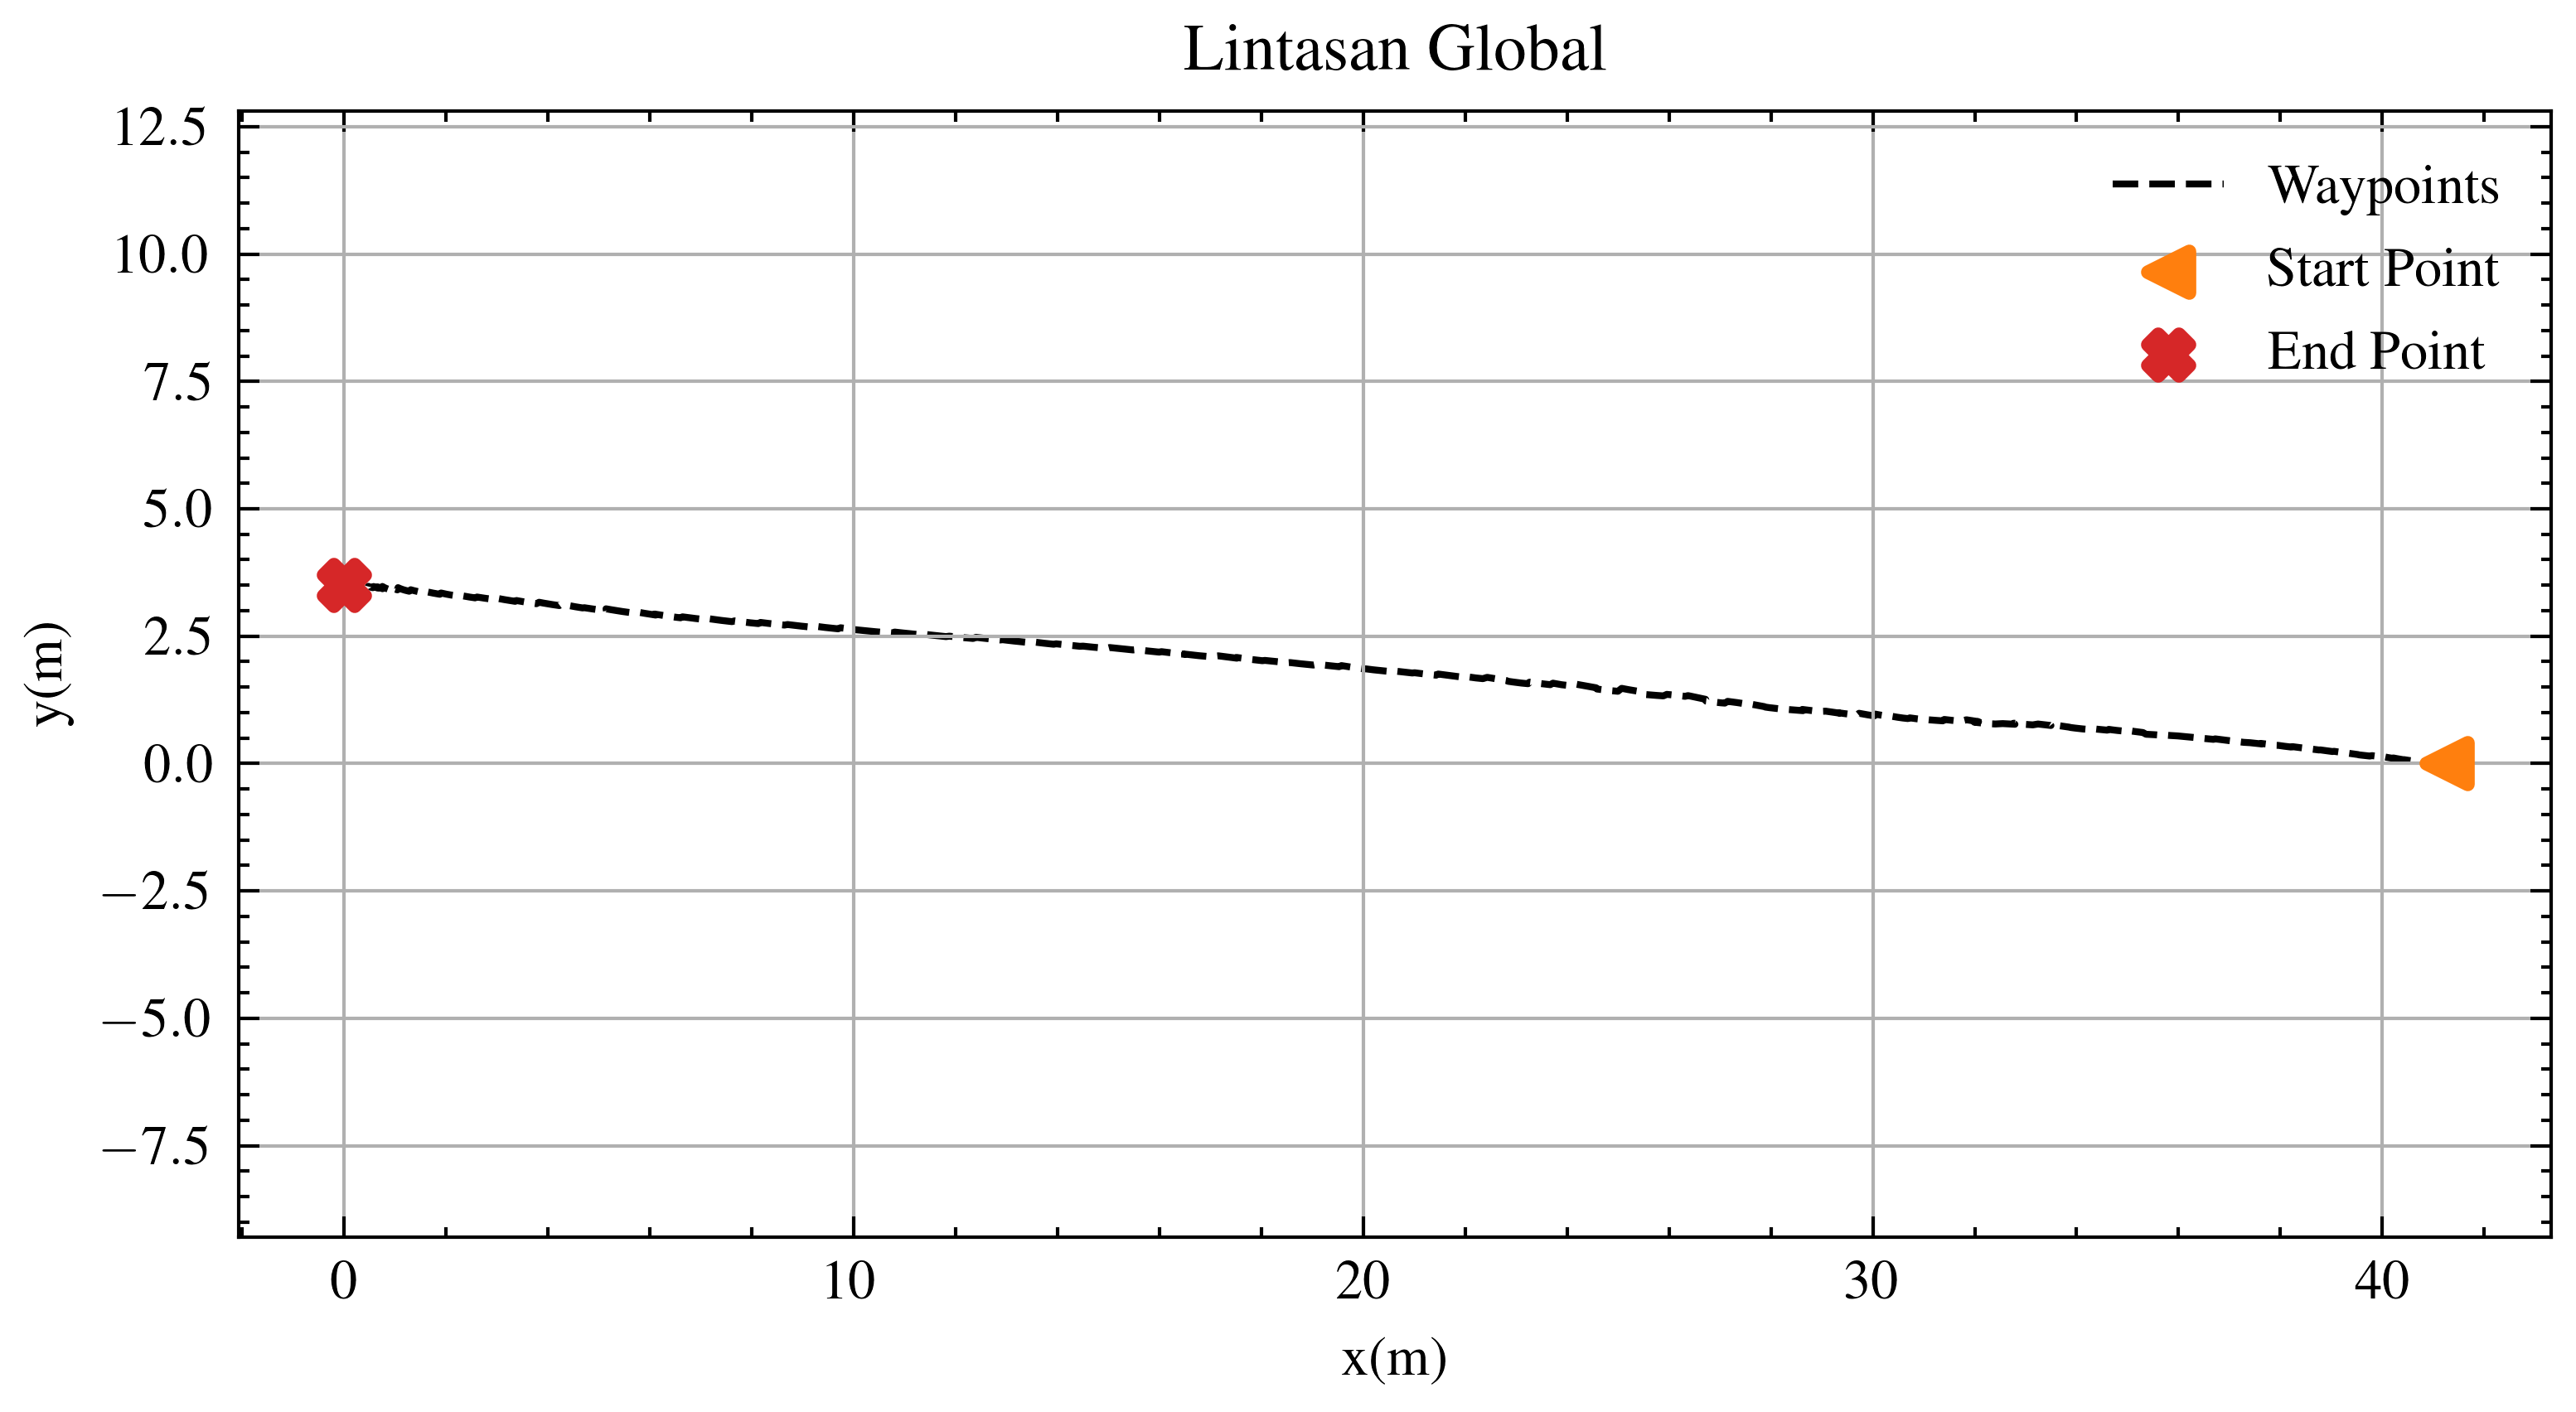

In [20]:
plt.style.use(['ieee', 'science'])
plt.figure(figsize=(6,3))

# Waypoints
plt.scatter(wp[0,0]-avg_x, wp[0,1]-avg_y, c='tab:orange', lw=2, zorder=2, marker='<', label='Start Point')
plt.scatter(wp[-1,0]-avg_x, wp[-1,1]-avg_y, c='tab:red', marker='X', lw=2, zorder=2, label='End Point')
plt.plot(wp[:,0]-avg_x, wp[:,1]-avg_y, '--', label="Waypoints", c="black", zorder=1)

plt.axis("equal")
plt.title('Lintasan Global')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.grid()
plt.savefig('img/'+_wpfilename+'_wp.png', dpi=300, facecolor='white')